# Import packages

In [1]:
import os
import shutil

import math

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import patches as patches
import seaborn as sns
import cv2
from PIL import Image

%matplotlib inline

# Dataset 1 - 80k

## Helper functions

In [2]:
# extract bounding box information into separate col

def extract_nested_list(it):
    if isinstance(it, list):
        for sub_it in it:
            yield from extract_nested_list(sub_it)
    elif isinstance(it, dict):
        for value in it.values():
            yield from extract_nested_list(value)
    else:
        yield it

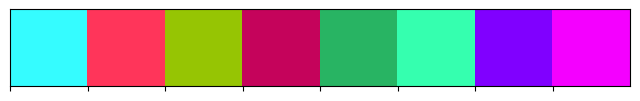

In [3]:
# Custom colors for plots

custom_colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#8000FF', '#F400FF']
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
rgbcolors = list(map(hex2rgb, custom_colors))[1:]
sns.palplot(sns.color_palette(custom_colors))

In [23]:
# Plot original image and image with bounding boxes

def plot_data_example(df: pd.DataFrame,
                      root_dir: str,
                      img_path: str, 
                      colors: dict):

    image = cv2.imread(os.path.join(root_dir, img_path)).astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = np.zeros(image.shape, dtype="uint8")

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25, 8))
    ax[1].imshow(image, aspect="auto")
    ax[1].set_title("Original Image", fontsize=22, fontweight='bold', y=1.07)
    ax[0].set_title("Image with Bounding Boxes", fontsize=22, fontweight='bold', y=1.07)


    bb_info = df.loc[df["pathname"] == img_path, ["x_min", "x_max", "y_min", "y_max", "category"]].values
    for i_bb in bb_info:

        cmin, cmax, rmin, rmax = i_bb[:-1].astype('int')
        label = i_bb[-1]
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1, 
                                 edgecolor=label2hex[label], facecolor='none')
        boxes[rmin:rmax, cmin:cmax] = label2rgb[label]

        ax[0].add_patch(bbox)
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))
        ax[0].imshow(image, aspect="auto")
        ax[0].imshow(boxes,  alpha=0.3, aspect="auto")
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))

    plt.tight_layout()
    plt.savefig("../data/data_eda/data_samples.png")
    plt.show()

In [6]:
# Global variable

root_dir = '../data/malaria_bbbc_80k/malaria/'

## Data preparation

In [7]:
# Load json files

train_df = pd.read_json("../data/malaria_bbbc_80k/malaria/training.json")
test_df = pd.read_json("../data/malaria_bbbc_80k/malaria/test.json")
print(train_df.shape, test_df.shape)

(1208, 2) (120, 2)


In [8]:
# check example

train_df.head()

image  \
0  {'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...   
1  {'checksum': '1225a18efce159eddf7b0e80e0ea642c...   
2  {'checksum': '3eaf840523c30fdf38897ffa01e194eb...   
3  {'checksum': '8a111dffacfa433029492780b9535091...   
4  {'checksum': 'ccef403e971460b86444cca669e68ca1...   

                                             objects  
0  [{'bounding_box': {'minimum': {'r': 1057, 'c':...  
1  [{'bounding_box': {'minimum': {'r': 734, 'c': ...  
2  [{'bounding_box': {'minimum': {'r': 724, 'c': ...  
3  [{'bounding_box': {'minimum': {'r': 563, 'c': ...  
4  [{'bounding_box': {'minimum': {'r': 618, 'c': ...

In [9]:
# check infomation in image col

train_df["image"][0]

{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af',
 'pathname': '/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png',
 'shape': {'r': 1200, 'c': 1600, 'channels': 3}}

In [10]:
# Create new cols for attributes

train_df["checksum"] = train_df['image'].apply(lambda x: x["checksum"])
train_df["pathname"] = train_df['image'].apply(lambda x: x["pathname"][1:])
train_df["shape"] = train_df['image'].apply(lambda x: x["shape"])
train_df.head()

image  \
0  {'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...   
1  {'checksum': '1225a18efce159eddf7b0e80e0ea642c...   
2  {'checksum': '3eaf840523c30fdf38897ffa01e194eb...   
3  {'checksum': '8a111dffacfa433029492780b9535091...   
4  {'checksum': 'ccef403e971460b86444cca669e68ca1...   

                                             objects  \
0  [{'bounding_box': {'minimum': {'r': 1057, 'c':...   
1  [{'bounding_box': {'minimum': {'r': 734, 'c': ...   
2  [{'bounding_box': {'minimum': {'r': 724, 'c': ...   
3  [{'bounding_box': {'minimum': {'r': 563, 'c': ...   
4  [{'bounding_box': {'minimum': {'r': 618, 'c': ...   

                           checksum  \
0  676bb8e86fc2dbf05dd97d51a64ac0af   
1  1225a18efce159eddf7b0e80e0ea642c   
2  3eaf840523c30fdf38897ffa01e194eb   
3  8a111dffacfa433029492780b9535091   
4  ccef403e971460b86444cca669e68ca1   

                                          pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/10be6380-cbbb-4886-8b9e-ff56b1710576.png   
2  images/6b14c855-8561-417c-97a4-63fa552842fd.png   
3  images/13099edb-35d9-438f-b093-2cf2ebf9d255.png   
4  images/2559636b-f01a-4414-93da-210c3b12d153.png   

                                   shape  
0  {'r': 1200, 'c': 1600, 'channels': 3}  
1  {'r': 1200, 'c': 1600, 'channels': 3}  
2  {'r': 1200, 'c': 1600, 'channels': 3}  
3  {'r': 1200, 'c': 1600, 'channels': 3}  
4  {'r': 1200, 'c': 1600, 'channels': 3}

In [11]:
# Check object information

train_df["objects"][0]

[{'bounding_box': {'minimum': {'r': 1057, 'c': 1440},
   'maximum': {'r': 1158, 'c': 1540}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 868, 'c': 1303},
   'maximum': {'r': 971, 'c': 1403}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 578, 'c': 900},
   'maximum': {'r': 689, 'c': 1008}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 304, 'c': 611},
   'maximum': {'r': 408, 'c': 713}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 198, 'c': 881},
   'maximum': {'r': 312, 'c': 1003}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 193, 'c': 1480},
   'maximum': {'r': 293, 'c': 1574}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 257, 'c': 1384},
   'maximum': {'r': 364, 'c': 1502}},
  'category': 'red blood cell'},
 {'bounding_box': {'minimum': {'r': 430, 'c': 302},
   'maximum': {'r': 533, 'c': 392}},
  'category': 'red blood cell'},
 {'bounding_

In [12]:
# Checking each bounding box

train_df["objects"][0][0]

{'bounding_box': {'minimum': {'r': 1057, 'c': 1440},
  'maximum': {'r': 1158, 'c': 1540}},
 'category': 'red blood cell'}

In [13]:
# create new dataframe with separate bounding boxes as row

df = pd.DataFrame(
    [
     dict(pathname=row['pathname'], 
          shape=row['shape'],
          checksum=row['checksum'],
          **bb_info) 
     for _, row in train_df.iterrows() 
     for bb_info in row['objects']
     ]
     )

df.head()

pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   

                                   shape                          checksum  \
0  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
1  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
2  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
3  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
4  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   

                                        bounding_box        category  
0  {'minimum': {'r': 1057, 'c': 1440}, 'maximum':...  red blood cell  
1  {'minimum': {'r': 868, 'c': 1303}, 'maximum': ...  red blood cell  
2  {'minimum': {'r': 578, 'c': 900}, 'maximum': {...  red blood cell  
3  {'minimum': {'r': 304, 'c': 611}, 'maximum': {...  red blood cell  
4  {'minimum': {'r': 198, 'c': 881}, 'maximum': {...  red blood cell

In [14]:
# Extract bounding box info to separate cols

df['x_min'] = -1
df['y_min'] = -1
df['x_max'] = -1
df['y_max'] = -1

df[['y_min', 'x_min', 'y_max', 'x_max']] = np.stack(df['bounding_box'].apply(lambda x: np.array(list(extract_nested_list(x)))))

df['x_min'] = df['x_min'].astype(float)
df['y_min'] = df['y_min'].astype(float)
df['x_max'] = df['x_max'].astype(float)
df['y_max'] = df['y_max'].astype(float)

df['w'] = df['x_max'] - df['x_min']
df['h'] = df['y_max'] - df['y_min']

df['x_center'] = df['x_min'] + df['w'] / 2
df['y_center'] = df['y_min'] + df['h'] / 2

df.drop(columns=['bounding_box'], inplace=True)

df.head()

pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   

                                   shape                          checksum  \
0  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
1  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
2  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
3  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
4  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   

         category   x_min   y_min   x_max   y_max      w      h  x_center  \
0  red blood cell  1440.0  1057.0  1540.0  1158.0  100.0  101.0    1490.0   
1  red blood cell  1303.0   868.0  1403.0   971.0  100.0  103.0    1353.0   
2  red blood cell   900.0   578.0  1008.0   689.0  108.0  111.0     954.0   
3  red blood cell   611.0   304.0   713.0   408.0  102.0  104.0     662.0   
4  red blood cell   881.0   198.0  1003.0   312.0  122.0  114.0     942.0   

   y_center  
0    1107.5  
1     919.5  
2     633.5  
3     356.0  
4     255.0

In [15]:
# Extract image shape info to separate cols

df['img_width'] = -1
df['img_height'] = -1
df['channels'] = -1
df['pixels'] = -1

df[['img_height','img_width', 'channels']] = np.stack(df['shape'].apply(lambda x: np.array(list(extract_nested_list(x)))))
df['pixels'] = df['img_width'] * df['img_height'] * df['channels']

df.drop(columns=['shape'], inplace=True)

df.head()

pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   

                           checksum        category   x_min   y_min   x_max  \
0  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1440.0  1057.0  1540.0   
1  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1303.0   868.0  1403.0   
2  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   900.0   578.0  1008.0   
3  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   611.0   304.0   713.0   
4  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   881.0   198.0  1003.0   

    y_max      w      h  x_center  y_center  img_width  img_height  channels  \
0  1158.0  100.0  101.0    1490.0    1107.5       1600        1200         3   
1   971.0  100.0  103.0    1353.0     919.5       1600        1200         3   
2   689.0  108.0  111.0     954.0     633.5       1600        1200         3   
3   408.0  102.0  104.0     662.0     356.0       1600        1200         3   
4   312.0  122.0  114.0     942.0     255.0       1600        1200         3   

    pixels  
0  5760000  
1  5760000  
2  5760000  
3  5760000  
4  5760000

In [16]:
# Check label value

df["category"].value_counts()

red blood cell    77420
trophozoite        1473
difficult           441
ring                353
schizont            179
gametocyte          144
leukocyte           103
Name: category, dtype: int64

In [17]:
# Encoding label

lb = LabelEncoder()
lb.fit(df["category"])
df["label"] = lb.transform(df["category"])

df.head()

pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   

                           checksum        category   x_min   y_min   x_max  \
0  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1440.0  1057.0  1540.0   
1  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1303.0   868.0  1403.0   
2  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   900.0   578.0  1008.0   
3  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   611.0   304.0   713.0   
4  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   881.0   198.0  1003.0   

    y_max      w      h  x_center  y_center  img_width  img_height  channels  \
0  1158.0  100.0  101.0    1490.0    1107.5       1600        1200         3   
1   971.0  100.0  103.0    1353.0     919.5       1600        1200         3   
2   689.0  108.0  111.0     954.0     633.5       1600        1200         3   
3   408.0  102.0  104.0     662.0     356.0       1600        1200         3   
4   312.0  122.0  114.0     942.0     255.0       1600        1200         3   

    pixels  label  
0  5760000      3  
1  5760000      3  
2  5760000      3  
3  5760000      3  
4  5760000      3

In [18]:
lb.classes_

# 7 classes
# difficult: 0, gametocyte: 1, leukocyte: 2, rbc: 3, ring: 4, schizont: 5, trophozoite: 6

array(['difficult', 'gametocyte', 'leukocyte', 'red blood cell', 'ring',
       'schizont', 'trophozoite'], dtype=object)

## EDA

### Class distribution

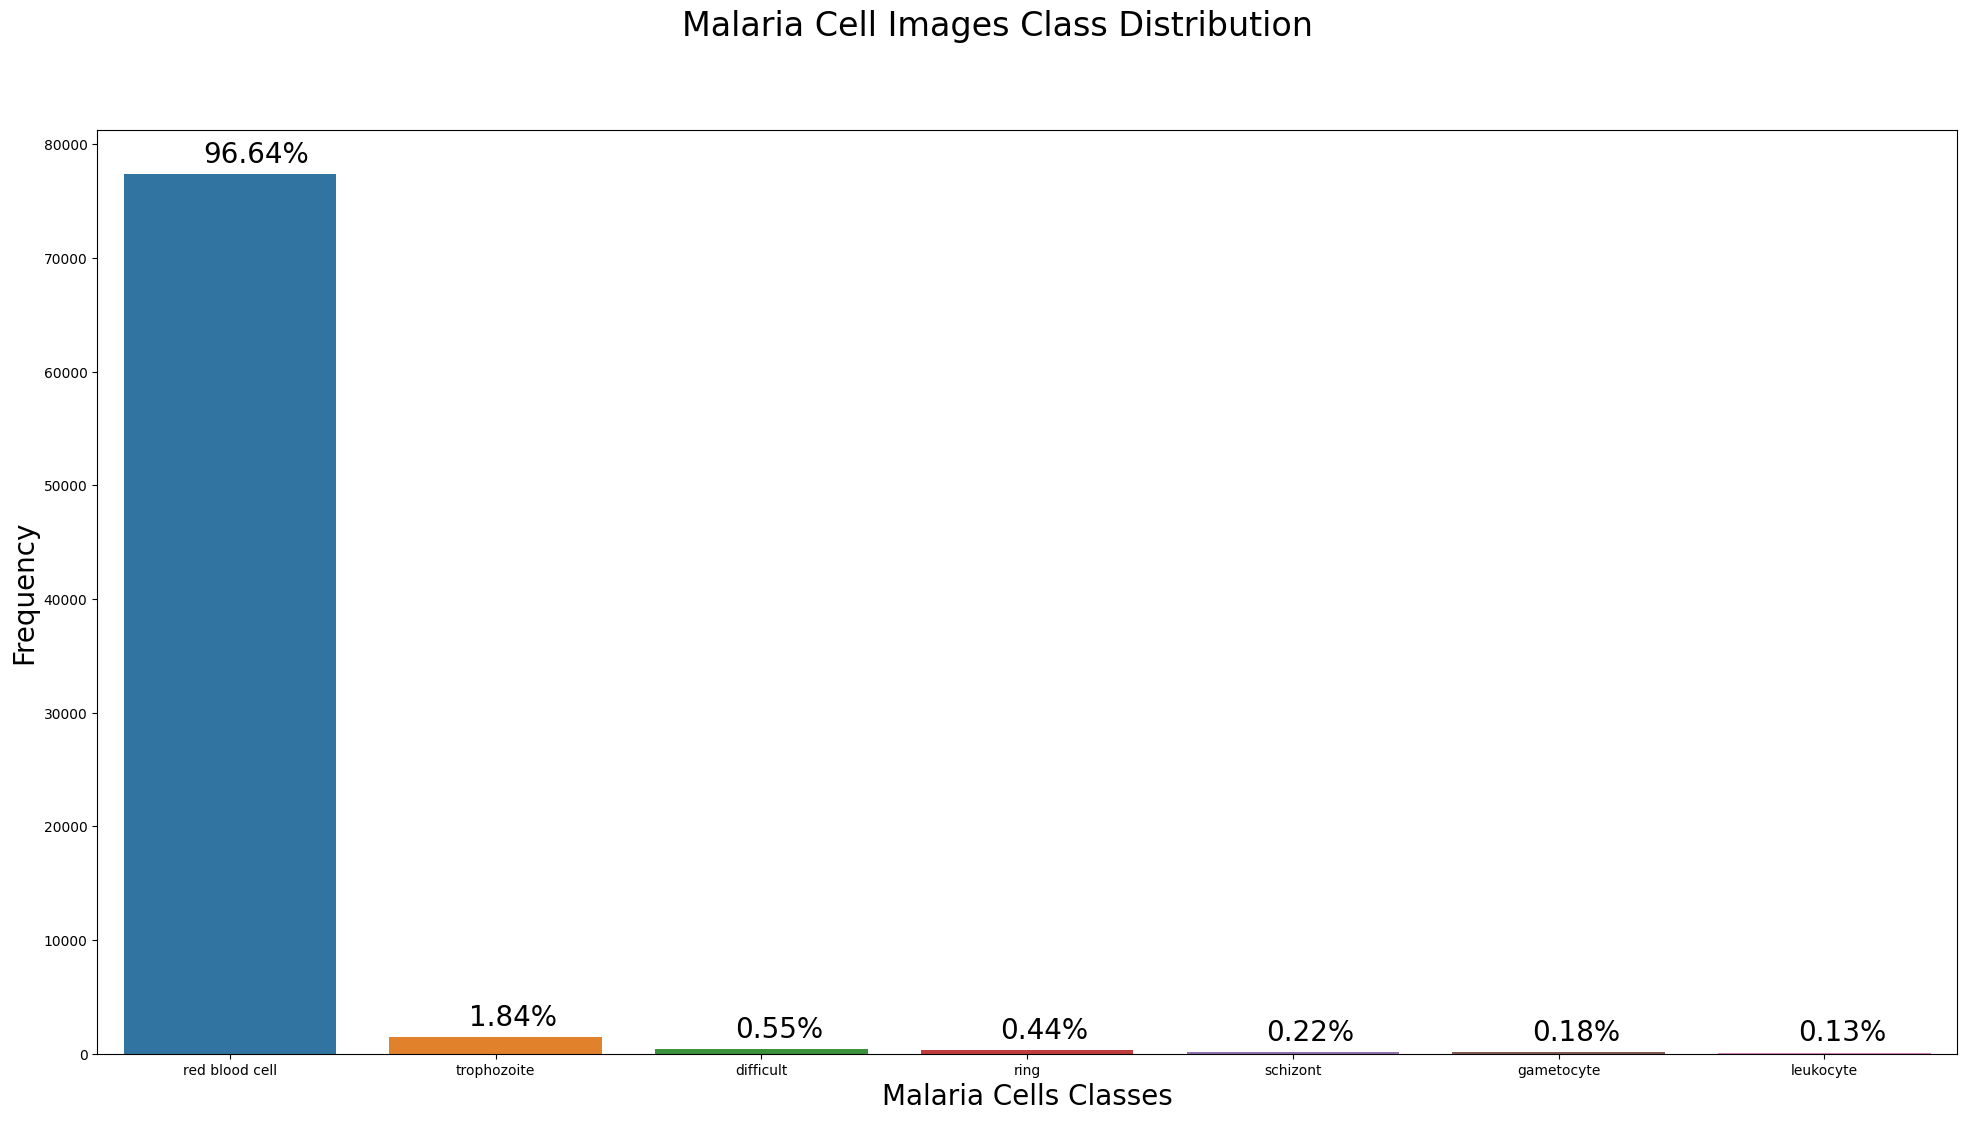

In [19]:
fig, ax = plt.subplots(figsize=(24,12))

temp = df['category'].value_counts().values

sns.barplot(x = df['category'].value_counts().index.tolist(), y = df['category'].value_counts().values.tolist())

for i,text in enumerate(df['category'].value_counts(normalize = True).items()):
    ax.annotate("{:.2f}%".format(text[1]*100),xy = (i-0.10,temp[i]+1000),fontsize = 20)
    
plt.xlabel("Malaria Cells Classes", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.suptitle("Malaria Cell Images Class Distribution", fontsize = 24)

plt.show()

### Distribution of Bounding Boxes in an Image

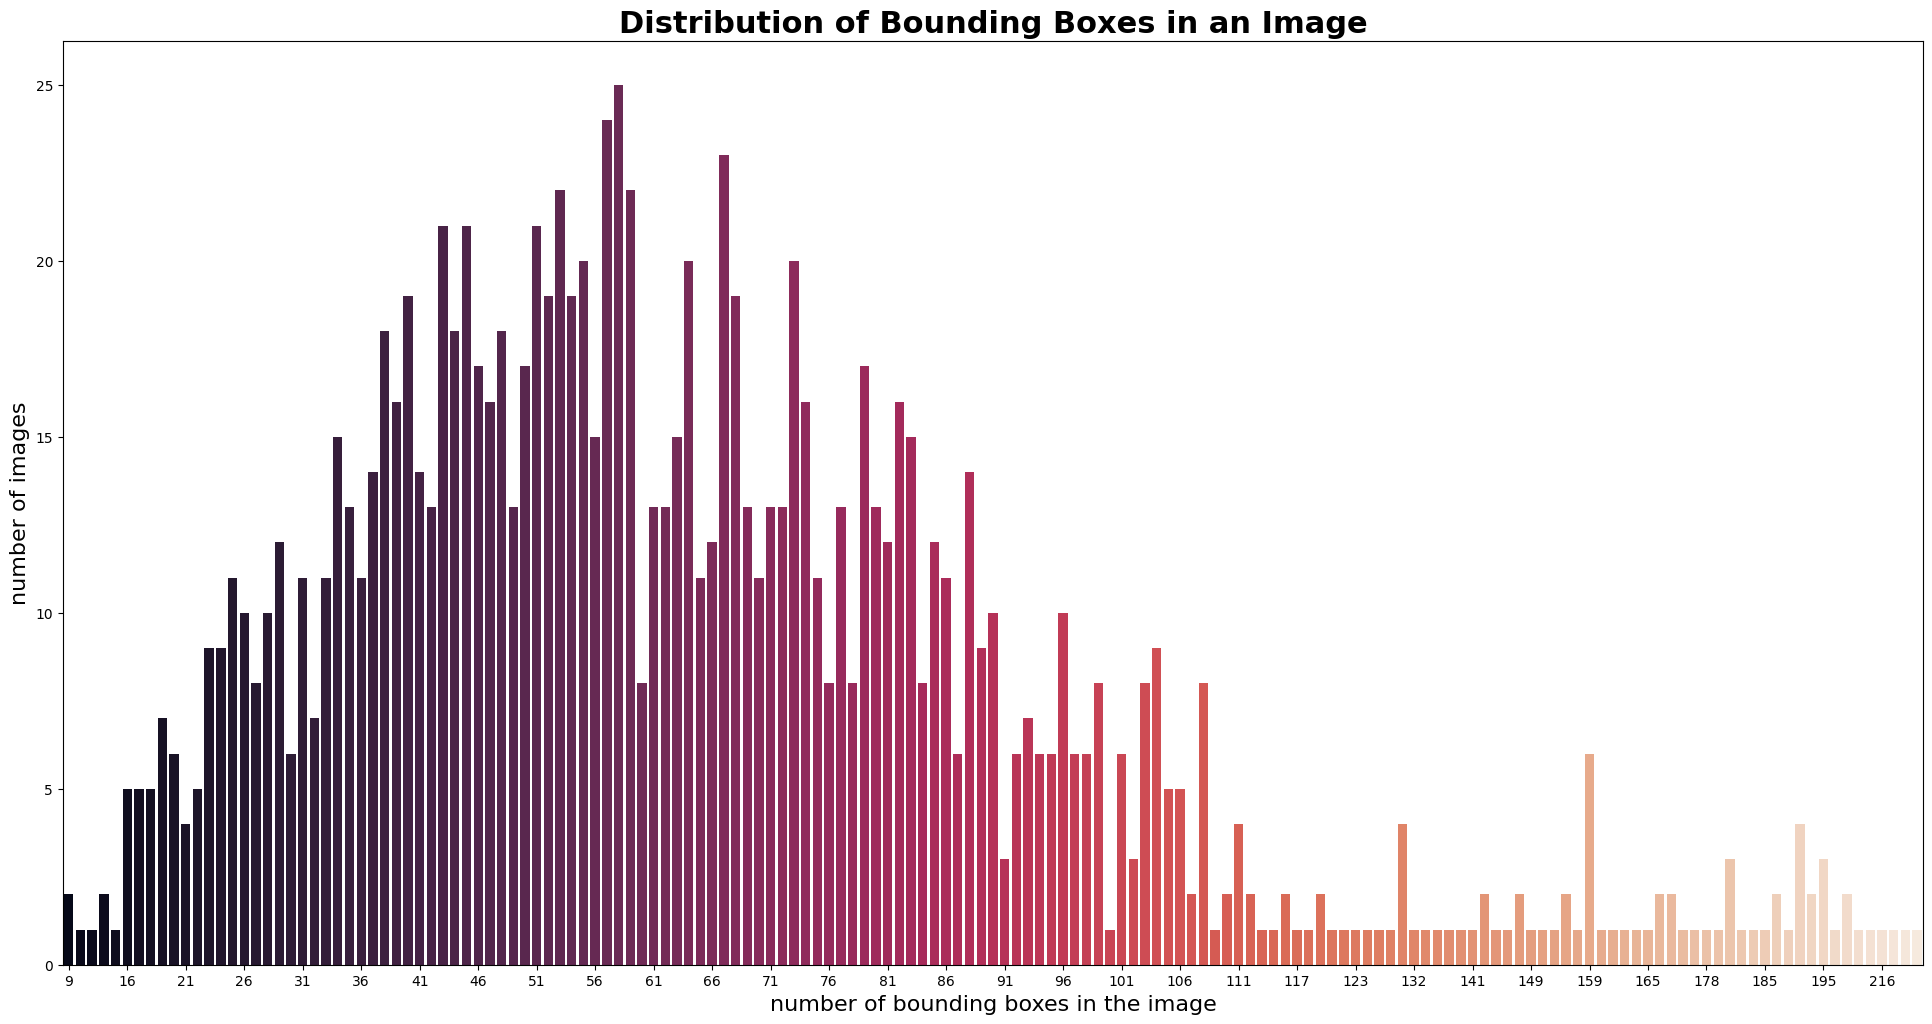

In [20]:
fig, ax = plt.subplots(figsize=(24,12))

sns.countplot(x=df.groupby('pathname')['checksum'].count(), palette='rocket')

ax.set_xticks(ax.get_xticks()[::5]);

ax.set_ylabel('number of images', fontsize=16)
ax.set_xlabel('number of bounding boxes in the image', fontsize=16)

ax.set_title("Distribution of Bounding Boxes in an Image", fontsize=22, fontweight='bold');

### Distribution of Image Dimensions

In [21]:
image_dimensions = df.drop_duplicates(subset=['pathname']).groupby(['img_width', 'img_height', 'channels']).count()['pathname'].to_dict()
image_dimensions

{(1600, 1200, 3): 1208}

### Plot samples

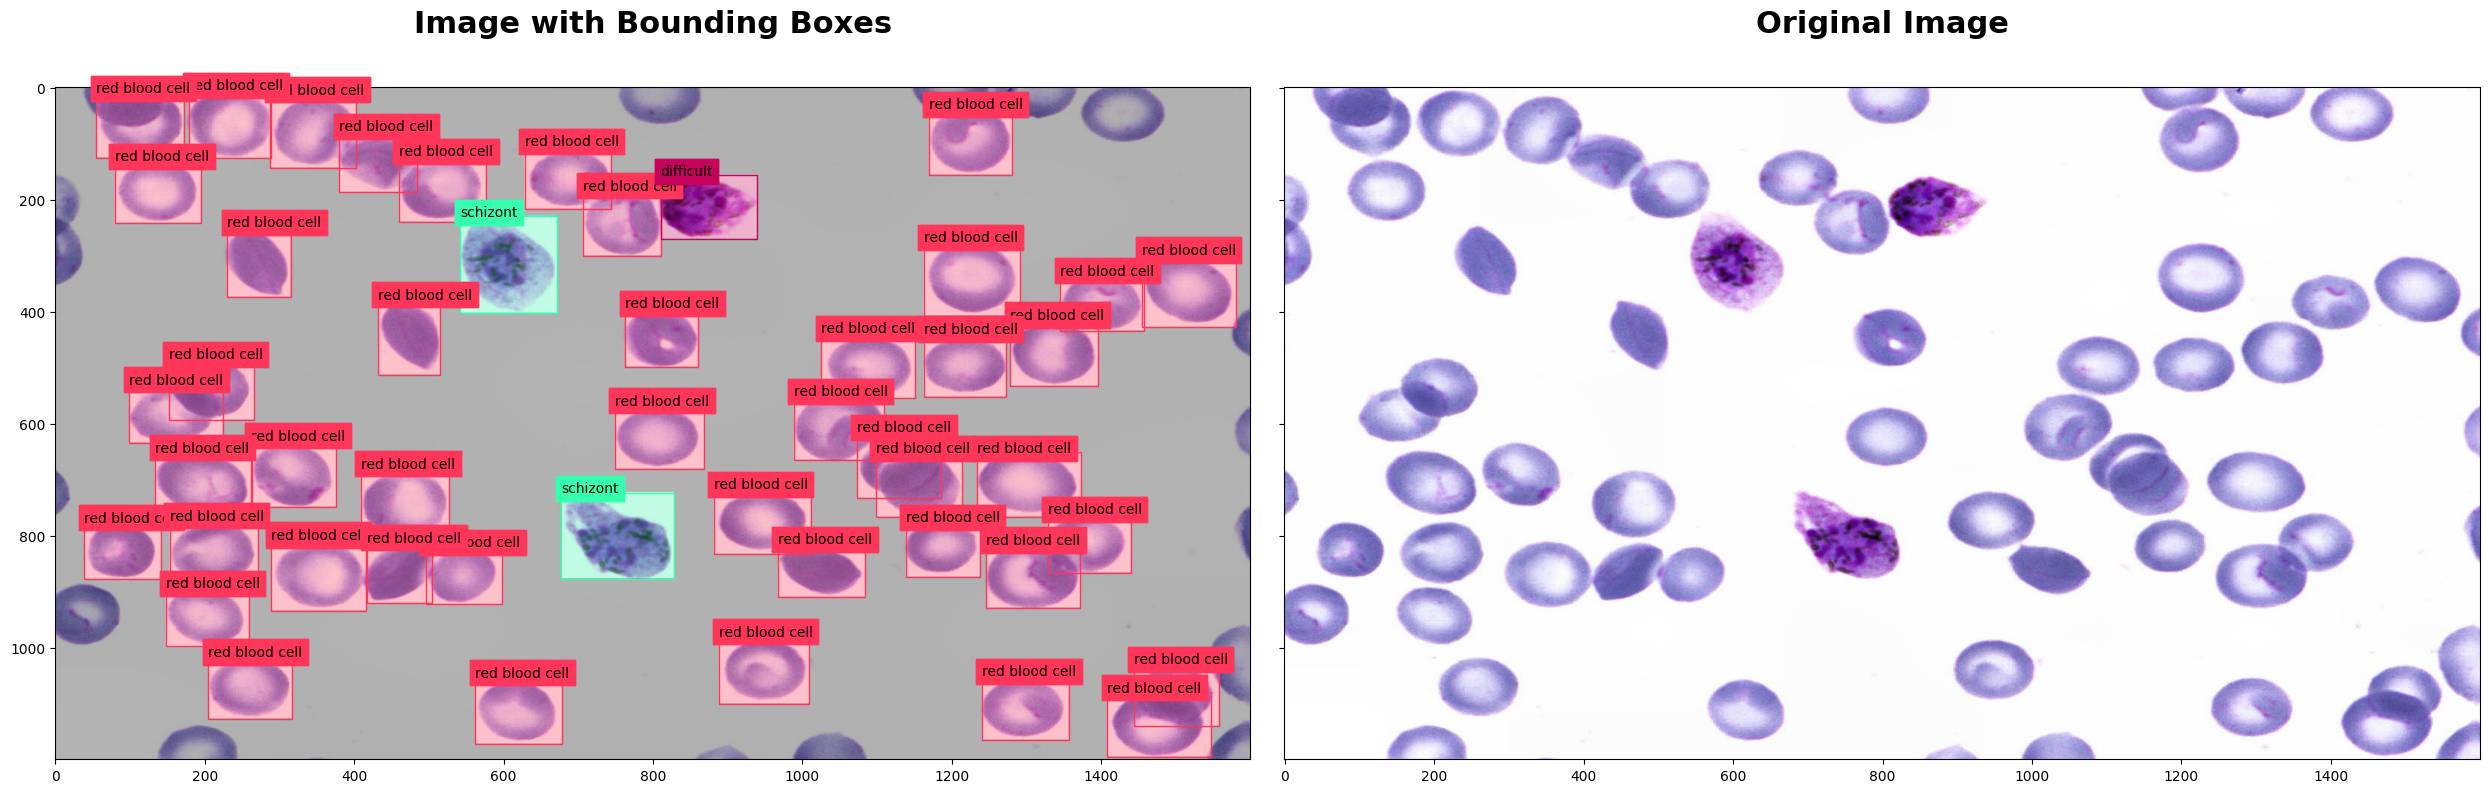

In [31]:
img_path = "images/0d2aba33-6920-4001-bd54-59fe0bf9f50e.png"

label2hex = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}
label2rgb = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), rgbcolors)}

plot_data_example(df, root_dir, img_path, colors=label2hex)

# Dataset 2 - 27558

## Helper functions

In [130]:
# Plot image

def plot_samples(no_samples, label, root_dir):
    
    plt.figure(figsize = (12,12))

    for i in range(no_samples):
        plt.subplot(1, 5, i+1)
        img = cv2.imread(os.path.join(root_dir, df[df['label'] == label]['path'].array[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.tight_layout()

    plt.show()

In [131]:
# Global variables

root_dir = "../data/cell_images_27558/cell_images"

## Data preparation

In [132]:
# Make dataframe

def data_prep(parasitized, uninfected):

    parasitized= ["Parasitized/" +  parasitize for parasitize in parasitized]
    uninfected= ["Uninfected/" +  uninfect for uninfect in uninfected]

    labels = len(parasitized)*['parasitized'] + len(uninfected)*['uninfected']
    data = parasitized + uninfected

    return pd.DataFrame({'path': data , 'label': labels})


df = data_prep(os.listdir(os.path.join(root_dir, "Parasitized/")), os.listdir(os.path.join(root_dir, "Uninfected/")))
df.head()

path        label
0  Parasitized/C100P61ThinF_IMG_20150918_144104_c...  parasitized
1  Parasitized/C100P61ThinF_IMG_20150918_144104_c...  parasitized
2  Parasitized/C100P61ThinF_IMG_20150918_144104_c...  parasitized
3  Parasitized/C100P61ThinF_IMG_20150918_144104_c...  parasitized
4  Parasitized/C100P61ThinF_IMG_20150918_144104_c...  parasitized

## EDA

### Plot images of each label

Parasitized Samples: 



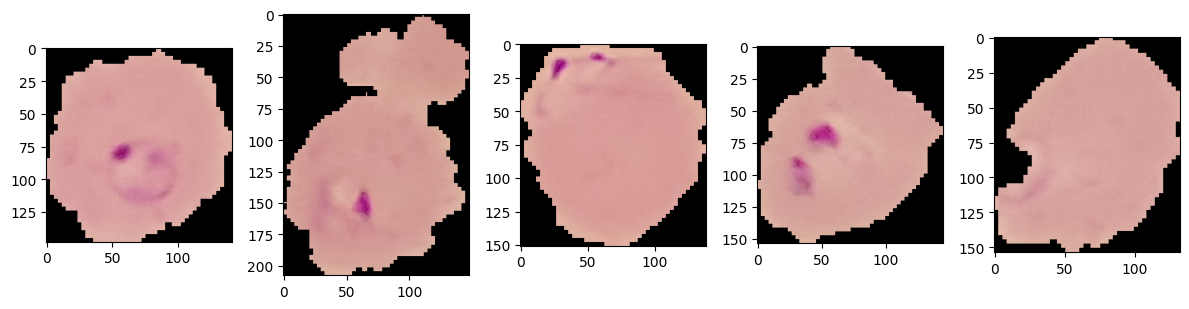


Uninfected Samples: 



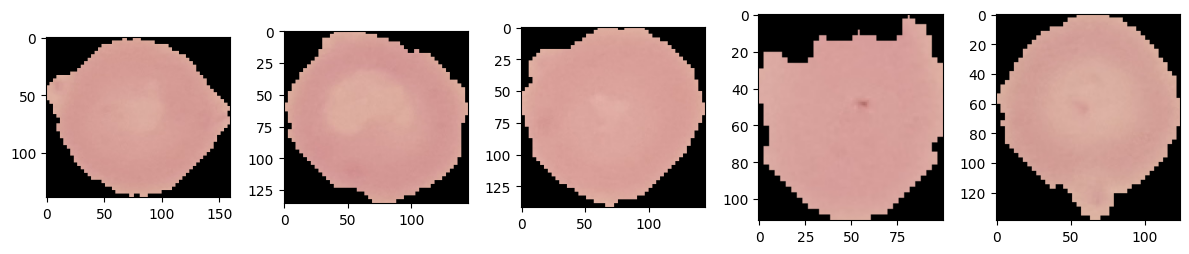

In [133]:
print("Parasitized Samples: ")
print()
plot_samples(5, 'parasitized', root_dir)


print()
print("Uninfected Samples: ")
print()
plot_samples(5, 'uninfected', root_dir)

### Distribution of samples

Text(0.5, 1.0, 'Distribution of samples according to the label')

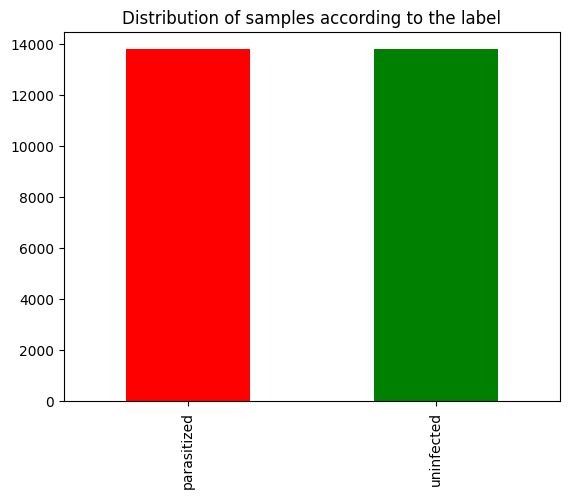

In [86]:
df['label'].value_counts().plot(kind = 'bar', color = ['red', 'green'])
plt.title('Distribution of samples according to the label')

# Dataset 3 - 150Pf

## Helper functions

In [2]:
# Global variables

root_dir_infected_falciparum = "../data/ThickBloodSmears_150/"
root_dir_infected_falciparum_annotate = "../data/ThickBloodSmears_150/GT_updated/"

In [3]:
# extract bounding box information into separate col

def extract_nested_list(it):
    if isinstance(it, list):
        for sub_it in it:
            yield from extract_nested_list(sub_it)
    elif isinstance(it, dict):
        for value in it.values():
            yield from extract_nested_list(value)
    else:
        yield it

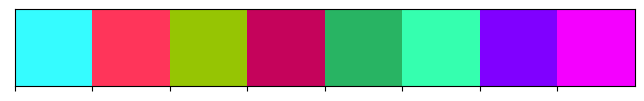

In [33]:
# Custom colors for plots

custom_colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#8000FF', '#F400FF']
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
rgbcolors = list(map(hex2rgb, custom_colors))[1:]
sns.palplot(sns.color_palette(custom_colors))

In [91]:
# Plot original image and image with bounding boxes

def plot_data_example(df: pd.DataFrame,
                      root_dir: str,
                      img_path: str, 
                      colors: dict):

    image = plt.imread(os.path.join(root_dir, img_path)).astype("uint8")
    boxes = np.zeros(image.shape, dtype="uint8")

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25, 8))
    ax[1].imshow(image)
    ax[1].set_title("Original Image", fontsize=22, fontweight='bold', y=1.07)
    ax[0].set_title("Image with Bounding Boxes", fontsize=22, fontweight='bold', y=1.07)


    bb_info = df.loc[df["path"] == img_path, ["x_min", "x_max", "y_min", "y_max", "category"]].values
    for i_bb in bb_info:
        print(i_bb)
        cmin, cmax, rmin, rmax = i_bb[:-1].astype('int')
        label = i_bb[-1]
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1, 
                                 edgecolor=label2hex[label], facecolor='none')
        boxes[rmin:rmax, cmin:cmax] = label2rgb[label]

        ax[0].add_patch(bbox)
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))
        ax[0].imshow(image)
        ax[0].imshow(boxes,  alpha=0.3)
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))

    plt.tight_layout()
    plt.show()

## Data preparation

In [106]:
df = pd.DataFrame(columns=["path", "img_width", "img_height", "objects", "label"])

In [107]:
# Extract annotation information from txt file

for dir in os.listdir(root_dir_infected_falciparum)[2:]:
    for f in os.listdir(os.path.join(root_dir_infected_falciparum, dir)):
        if f != "Thumbs.db":
            try:
                file = open(os.path.join(root_dir_infected_falciparum_annotate, dir + "/" + f.split(".")[0] + ".txt"), "r")
                lines = file.readlines()
                
                object = []
                for line in lines[1:]:
                    data = line.split(",")
                    if data[1] == "Parasite":
                        x_center = float(data[5])
                        y_center = float(data[6])
                        x_temp = float(data[7])
                        y_temp = float(data[8])
                        r = float(math.sqrt((x_temp - x_center) ** 2 + (y_temp - y_center) ** 2))
                        x_min = float(x_center - r - 50)
                        y_min = float(y_center - r - 50)
                        x_max = float(x_center + r + 50)
                        y_max = float(y_center + r + 50)
                        object.append({'bounding_box': {'minimum': {'x': x_min, 'y': y_min},
                                                        'maximum':{'x': x_max, 'y': y_max}},
                                      'category': 'parasite'})
                        
                    else:
                        x_center = float(data[5])
                        y_center = float(data[6])
                        x_min = float(x_center - 50)
                        y_min = float(y_center - 50)
                        x_max = float(x_center + 50)
                        y_max = float(y_center + 50)
                        object.append({'bounding_box': {'minimum': {'x': x_min, 'y': y_min},
                                                        'maximum':{'x': x_max, 'y': y_max}},
                                      'category': 'wbc'})
                        
                df.loc[len(df)]= [dir + "/" + f, lines[0].split(",")[2].strip(), lines[0].split(",")[1], object, "infected_f"]
                        
            except FileNotFoundError as e:
                print(f)
                print(e)
                shutil.move(os.path.join(root_dir_infected_falciparum, dir + "/" + f), "../data/ThickBloodSmears_150_MissAnotation/"+f)

In [108]:
df.head()

path img_width img_height  \
0  TF100_CS39/20170829_205107.jpg      3024       4032   
1  TF100_CS39/20170829_205324.jpg      3024       4032   
2  TF100_CS39/20170829_205527.jpg      3024       4032   
3  TF100_CS39/20170829_205620.jpg      3024       4032   
4  TF100_CS39/20170829_205809.jpg      3024       4032   

                                             objects       label  
0  [{'bounding_box': {'minimum': {'x': 2077.25, '...  infected_f  
1  [{'bounding_box': {'minimum': {'x': 1446.3, 'y...  infected_f  
2  [{'bounding_box': {'minimum': {'x': 1242.79746...  infected_f  
3  [{'bounding_box': {'minimum': {'x': 2346.77275...  infected_f  
4  [{'bounding_box': {'minimum': {'x': 1605.51242...  infected_f

In [109]:
df.shape

(1830, 5)

In [110]:
# create new dataframe with separate bounding boxes as row

df = pd.DataFrame(
    [
     dict(path=row['path'], 
          img_width=row['img_width'],
          img_height=row['img_height'],
          **bb_info,
         label=row['label']) 
     for _, row in df.iterrows() 
     for bb_info in row['objects']
     ]
     )

df.head()

path img_width img_height  \
0  TF100_CS39/20170829_205107.jpg      3024       4032   
1  TF100_CS39/20170829_205107.jpg      3024       4032   
2  TF100_CS39/20170829_205107.jpg      3024       4032   
3  TF100_CS39/20170829_205107.jpg      3024       4032   
4  TF100_CS39/20170829_205107.jpg      3024       4032   

                                        bounding_box  category       label  
0  {'minimum': {'x': 2077.25, 'y': 1122.449999999...  parasite  infected_f  
1  {'minimum': {'x': 1873.4563479797016, 'y': 237...  parasite  infected_f  
2  {'minimum': {'x': 1973.65, 'y': 1332.550000000...  parasite  infected_f  
3  {'minimum': {'x': 2025.9536942914988, 'y': 123...  parasite  infected_f  
4  {'minimum': {'x': 1492.4555080537991, 'y': 137...  parasite  infected_f

In [111]:
# Extract bounding box info to separate cols

df['x_min'] = -1
df['y_min'] = -1
df['x_max'] = -1
df['y_max'] = -1

df[['x_min', 'y_min', 'x_max', 'y_max']] = np.stack(df['bounding_box'].apply(lambda x: np.array(list(extract_nested_list(x)))))

df['x_min'] = df['x_min'].astype(float)
df['y_min'] = df['y_min'].astype(float)
df['x_max'] = df['x_max'].astype(float)
df['y_max'] = df['y_max'].astype(float)

df['x_center'] = (df['x_min'] + df['x_max']) / 2
df['y_center'] = (df['y_min'] + df['y_max']) / 2

df.drop(columns=['bounding_box'], inplace=True)

df.head()

path img_width img_height  category       label  \
0  TF100_CS39/20170829_205107.jpg      3024       4032  parasite  infected_f   
1  TF100_CS39/20170829_205107.jpg      3024       4032  parasite  infected_f   
2  TF100_CS39/20170829_205107.jpg      3024       4032  parasite  infected_f   
3  TF100_CS39/20170829_205107.jpg      3024       4032  parasite  infected_f   
4  TF100_CS39/20170829_205107.jpg      3024       4032  parasite  infected_f   

         x_min        y_min        x_max        y_max  x_center  y_center  
0  2077.250000  1122.450000  2214.950000  1260.150000   2146.10   1191.30  
1  1873.456348  2374.706348  2037.643652  2538.893652   1955.55   2456.80  
2  1973.650000  1332.550000  2111.450000  1470.350000   2042.55   1401.45  
3  2025.953694  1237.703694  2163.846306  1375.596306   2094.90   1306.65  
4  1492.455508  1374.505508  1621.044492  1503.094492   1556.75   1438.80

In [112]:
df.shape

(119958, 11)

[2077.25 2214.95 1122.4499999999998 1260.15 'parasite']
[1873.4563479797016 2037.6436520202983 2374.7063479797016
 2538.8936520202988 'parasite']
[1973.65 2111.45 1332.5500000000002 1470.35 'parasite']
[2025.9536942914988 2163.8463057085014 1237.7036942914986
 1375.5963057085016 'parasite']
[1492.4555080537991 1621.0444919462009 1374.505508053799
 1503.0944919462008 'parasite']
[1583.4876813210865 1725.7123186789133 1000.6376813210866
 1142.8623186789134 'parasite']
[1037.75 1179.75 870.6 1012.6 'parasite']
[1253.6083694396575 1401.6916305603427 1394.8583694396575
 1542.9416305603427 'parasite']
[2228.7998134334853 2382.4001865665145 1768.049813433485
 1921.6501865665148 'parasite']
[2353.15 2492.15 2188.35 2327.35 'parasite']
[2108.95 2208.95 288.65 388.65 'wbc']
[2051.85 2151.85 390.25 490.25 'wbc']
[2204.2 2304.2 358.5 458.5 'wbc']
[2121.65 2221.65 422.0 522.0 'wbc']
[2235.95 2335.95 453.75 553.75 'wbc']
[2058.15 2158.15 1063.3 1163.3 'wbc']
[2623.3 2723.3 917.3 1017.3 'wbc']
[1188.

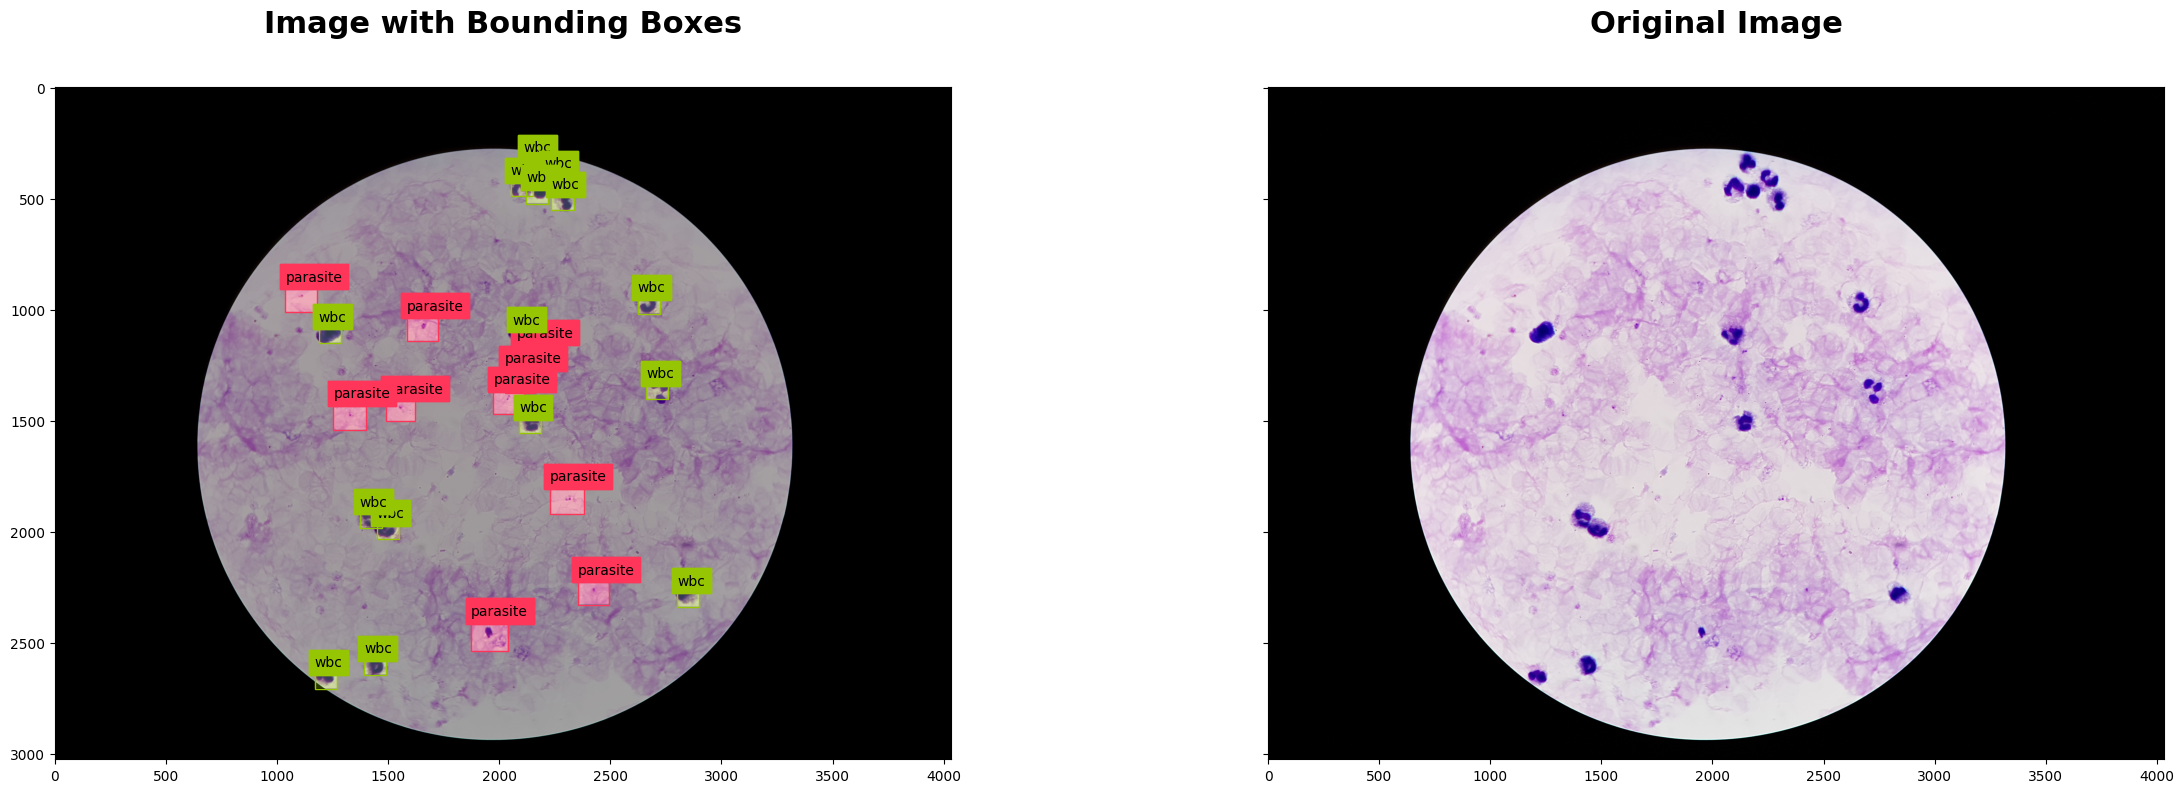

In [113]:
# plot sample

img_path = df["path"][1]

label2hex = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}
label2rgb = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), rgbcolors)}

plot_data_example(df, root_dir_infected_falciparum, img_path, colors=label2hex)

## EDA

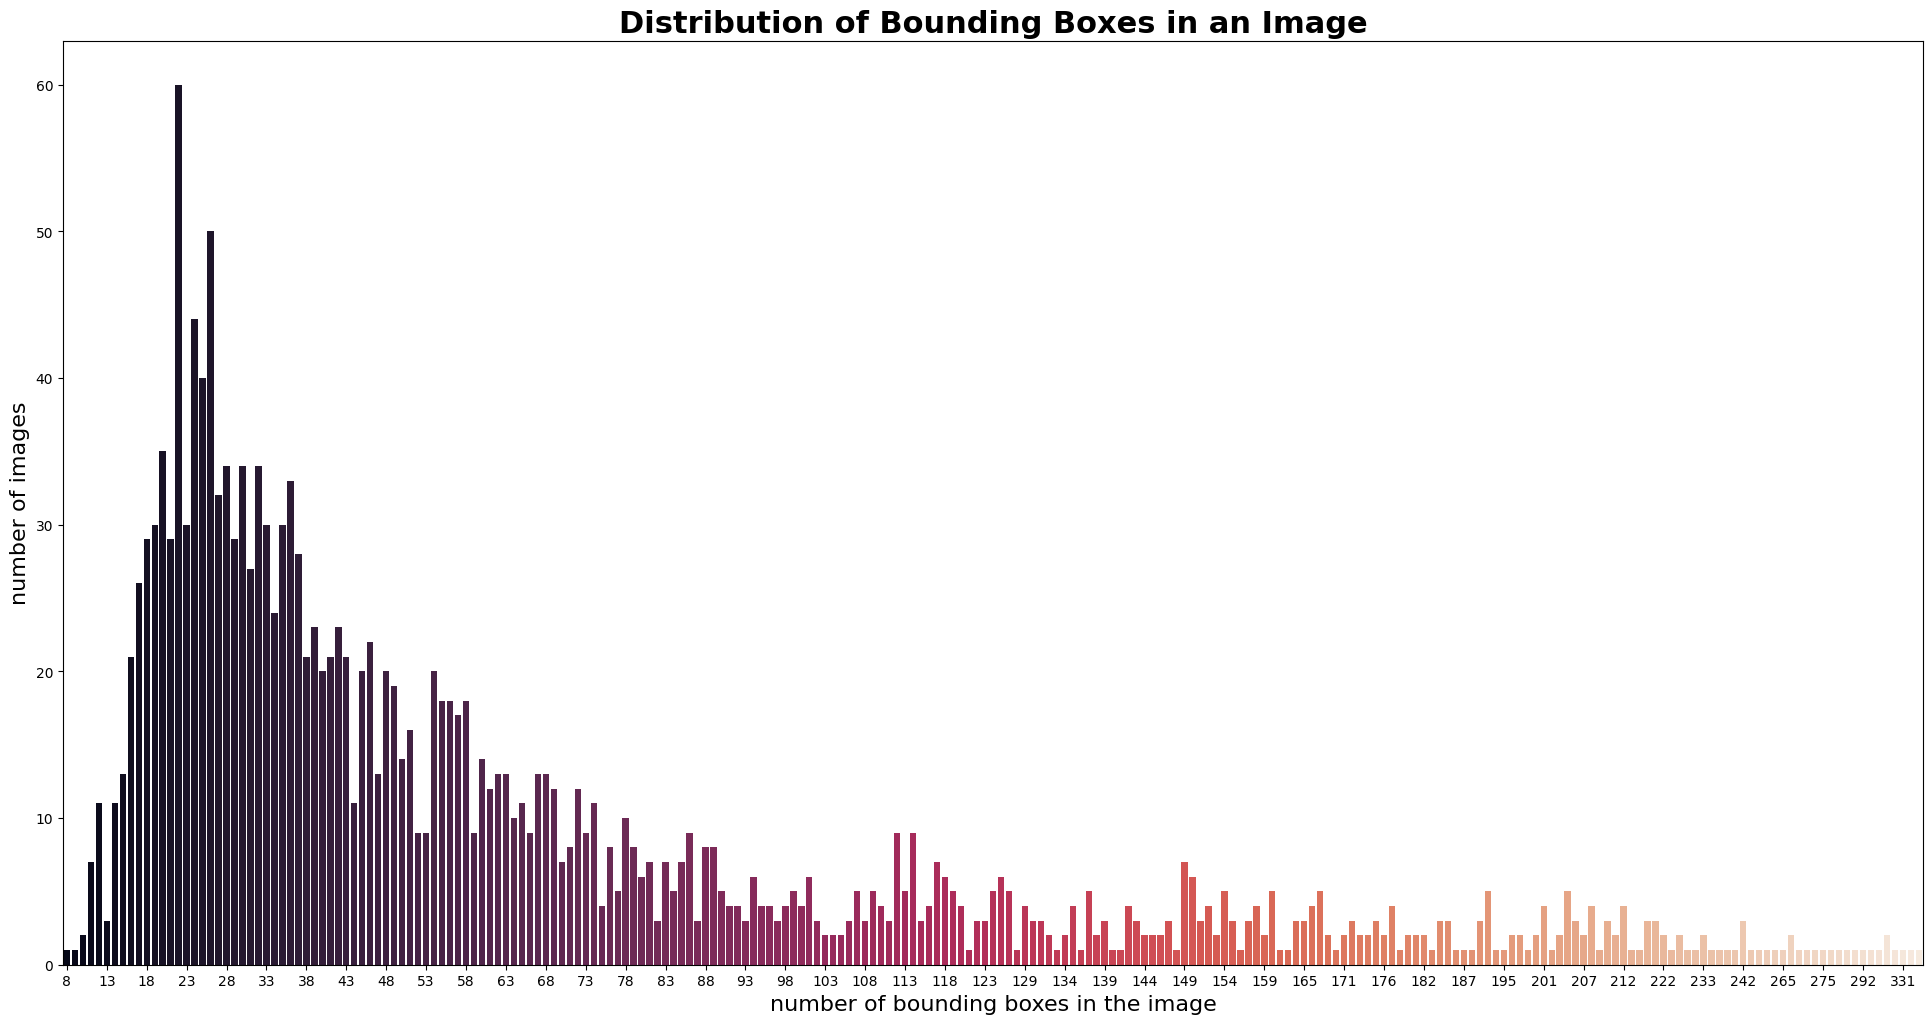

In [116]:
fig, ax = plt.subplots(figsize=(24,12))

sns.countplot(x=df.groupby('path')['path'].count(), palette='rocket')

ax.set_xticks(ax.get_xticks()[::5]);

ax.set_ylabel('number of images', fontsize=16)
ax.set_xlabel('number of bounding boxes in the image', fontsize=16)

ax.set_title("Distribution of Bounding Boxes in an Image", fontsize=22, fontweight='bold');

# Dataset 4 - ThinPf

## Helper function

In [3]:
# global variables

root_dir_point = "../data/NIH-NLM-ThinBloodSmearsPf/Point Set/"
root_dir_polygon = "../data/NIH-NLM-ThinBloodSmearsPf/Polygon Set/"

In [4]:
# extract bounding box information into separate col

def extract_nested_list(it):
    if isinstance(it, list):
        for sub_it in it:
            yield from extract_nested_list(sub_it)
    elif isinstance(it, dict):
        for value in it.values():
            yield from extract_nested_list(value)
    else:
        yield it

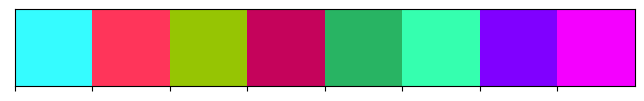

In [5]:
# Custom colors for plots

custom_colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#8000FF', '#F400FF']
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
rgbcolors = list(map(hex2rgb, custom_colors))[1:]
sns.palplot(sns.color_palette(custom_colors))

In [31]:
# Plot original image and image with bounding boxes

def plot_data_example(df: pd.DataFrame,
                      root_dir: str,
                      img_path: str, 
                      colors: dict):

    image = cv2.imread(os.path.join(root_dir, img_path)).astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = np.zeros(image.shape, dtype="uint8")

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25, 8))
    ax[1].imshow(image)
    ax[1].set_title("Original Image", fontsize=22, fontweight='bold', y=1.07)
    ax[0].set_title("Image with Bounding Boxes", fontsize=22, fontweight='bold', y=1.07)


    bb_info = df.loc[df["path"] == img_path, ["x_min", "x_max", "y_min", "y_max", "category"]].values
    for i_bb in bb_info[:10]:
        print(i_bb)
        cmin, cmax, rmin, rmax = i_bb[:-1].astype('int')
        label = i_bb[-1]
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1, 
                                 edgecolor=label2hex[label], facecolor='none')
        boxes[rmin:rmax, cmin:cmax] = label2rgb[label]

        ax[0].add_patch(bbox)
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))
        ax[0].imshow(image)
        ax[0].imshow(boxes,  alpha=0.3)
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))

    plt.tight_layout()
    plt.show()

## Data preparation

In [16]:
df = pd.DataFrame(columns=["path", "img_width", "img_height", "objects", "label"])

In [17]:
# Extract annotation information from txt file

for dir in os.listdir(root_dir_polygon):
    for f in os.listdir(os.path.join(root_dir_polygon, dir + "/Img")):
        
        if f != "Thumbs.db":
            try:
                file = open(os.path.join(root_dir_polygon, dir + "/GT/" + f.split(".")[0] + ".txt"), "r")
                lines = file.readlines()
                
                object = []
                for line in lines[1:]:
                    data = line.split(",")
                    n = int(data[4])
                    for i in range(n):
                        x_center = float(data[5 + 2*i])
                        y_center = float(data[6 + 2*i])
                        x_min = float(x_center - 50)
                        y_min = float(y_center - 50)
                        x_max = float(x_center + 50)
                        y_max = float(y_center + 50)
                        object.append({'bounding_box': {'minimum': {'x': x_min, 'y': y_min},
                                                        'maximum':{'x': x_max, 'y': y_max}},
                                      'category': data[1]})
                        
                df.loc[len(df)]= [dir + "/Img/" + f, lines[0].split(",")[1].strip(), lines[0].split(",")[2].strip(), object, "infected_f"]
                        
            except FileNotFoundError as e:
                print(f)
                print(e)
                shutil.move(os.path.join(root_dir_polygon, dir + "/Img/" + f), "../data/ThinBloodSmearsPf_MissAnnotation/"+f)

In [18]:
# Extract annotation information from txt file

for dir in os.listdir(root_dir_point):
    for f in os.listdir(os.path.join(root_dir_point, dir + "/Img")):
        
        if f != "Thumbs.db":
            try:
                file = open(os.path.join(root_dir_point, dir + "/GT/" + f.split(".")[0] + ".txt"), "r")
                lines = file.readlines()
                
                object = []
                for line in lines[1:]:
                    data = line.split(",")
                    
                    x_center = float(data[5])
                    y_center = float(data[6])
                    x_min = float(x_center - 50)
                    y_min = float(y_center - 50)
                    x_max = float(x_center + 50)
                    y_max = float(y_center + 50)
                    object.append({'bounding_box': {'minimum': {'x': x_min, 'y': y_min},
                                                    'maximum':{'x': x_max, 'y': y_max}},
                                  'category': data[1]})
                        
                df.loc[len(df)]= [dir + "/Img/" + f, lines[0].split(",")[1].strip(), lines[0].split(",")[2].strip(), object, "infected_f"]
                        
            except FileNotFoundError as e:
                print(f)
                print(e)
                shutil.move(os.path.join(root_dir_point, dir + "/Img/" + f), "../data/ThinBloodSmearsPf_MissAnnotation/"+f)

In [19]:
df.head()

path img_width img_height  \
0  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   
1  142C38P3thinF_original/Img/IMG_20150621_112043...      5312       2988   
2  142C38P3thinF_original/Img/IMG_20150621_112116...      5312       2988   
3  142C38P3thinF_original/Img/IMG_20150621_112138...      5312       2988   
4  142C38P3thinF_original/Img/IMG_20150621_112227...      5312       2988   

                                             objects       label  
0  [{'bounding_box': {'minimum': {'x': 2364.05, '...  infected_f  
1  [{'bounding_box': {'minimum': {'x': 3574.45, '...  infected_f  
2  [{'bounding_box': {'minimum': {'x': 1653.0, 'y...  infected_f  
3  [{'bounding_box': {'minimum': {'x': 3686.2, 'y...  infected_f  
4  [{'bounding_box': {'minimum': {'x': 2795.75, '...  infected_f

In [20]:
df.shape

(965, 5)

In [21]:
# create new dataframe with separate bounding boxes as row

df = pd.DataFrame(
    [
     dict(path=row['path'], 
          img_width=row['img_width'],
          img_height=row['img_height'],
          **bb_info,
         label=row['label']) 
     for _, row in df.iterrows() 
     for bb_info in row['objects']
     ]
     )

df.head()

path img_width img_height  \
0  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   
1  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   
2  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   
3  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   
4  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   

                                        bounding_box    category       label  
0  {'minimum': {'x': 2364.05, 'y': 1657.0}, 'maxi...  Uninfected  infected_f  
1  {'minimum': {'x': 2366.4, 'y': 1619.85}, 'maxi...  Uninfected  infected_f  
2  {'minimum': {'x': 2381.5, 'y': 1596.55}, 'maxi...  Uninfected  infected_f  
3  {'minimum': {'x': 2405.9, 'y': 1580.3}, 'maxim...  Uninfected  infected_f  
4  {'minimum': {'x': 2438.45, 'y': 1579.05}, 'max...  Uninfected  infected_f

In [22]:
# Extract bounding box info to separate cols

df['x_min'] = -1
df['y_min'] = -1
df['x_max'] = -1
df['y_max'] = -1

df[['x_min', 'y_min', 'x_max', 'y_max']] = np.stack(df['bounding_box'].apply(lambda x: np.array(list(extract_nested_list(x)))))

df['x_min'] = df['x_min'].astype(float)
df['y_min'] = df['y_min'].astype(float)
df['x_max'] = df['x_max'].astype(float)
df['y_max'] = df['y_max'].astype(float)

df['x_center'] = (df['x_min'] + df['x_max']) / 2
df['y_center'] = (df['y_min'] + df['y_max']) / 2

df.drop(columns=['bounding_box'], inplace=True)

df.head()

path img_width img_height  \
0  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   
1  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   
2  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   
3  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   
4  142C38P3thinF_original/Img/IMG_20150621_112023...      5312       2988   

     category       label    x_min    y_min    x_max    y_max  x_center  \
0  Uninfected  infected_f  2364.05  1657.00  2464.05  1757.00   2414.05   
1  Uninfected  infected_f  2366.40  1619.85  2466.40  1719.85   2416.40   
2  Uninfected  infected_f  2381.50  1596.55  2481.50  1696.55   2431.50   
3  Uninfected  infected_f  2405.90  1580.30  2505.90  1680.30   2455.90   
4  Uninfected  infected_f  2438.45  1579.05  2538.45  1679.05   2488.45   

   y_center  
0   1707.00  
1   1669.85  
2   1646.55  
3   1630.30  
4   1629.05

In [23]:
df.shape

(839885, 11)

[3510.85 3610.85 122.94999999999999 222.95 'Parasitized']
[2485.25 2585.25 195.7 295.7 'Parasitized']
[3185.15 3285.15 2800.1 2900.1 'Uninfected']
[3012.65 3112.65 2715.1 2815.1 'Uninfected']
[2922.65 3022.65 2797.6 2897.6 'Uninfected']
[2937.65 3037.65 1502.55 1602.55 'Uninfected']
[2740.1 2840.1 1867.6 1967.6 'Uninfected']
[2775.1 2875.1 2122.6 2222.6 'Uninfected']
[2602.6 2702.6 1802.55 1902.55 'Uninfected']
[2677.65 2777.65 2180.1 2280.1 'Uninfected']


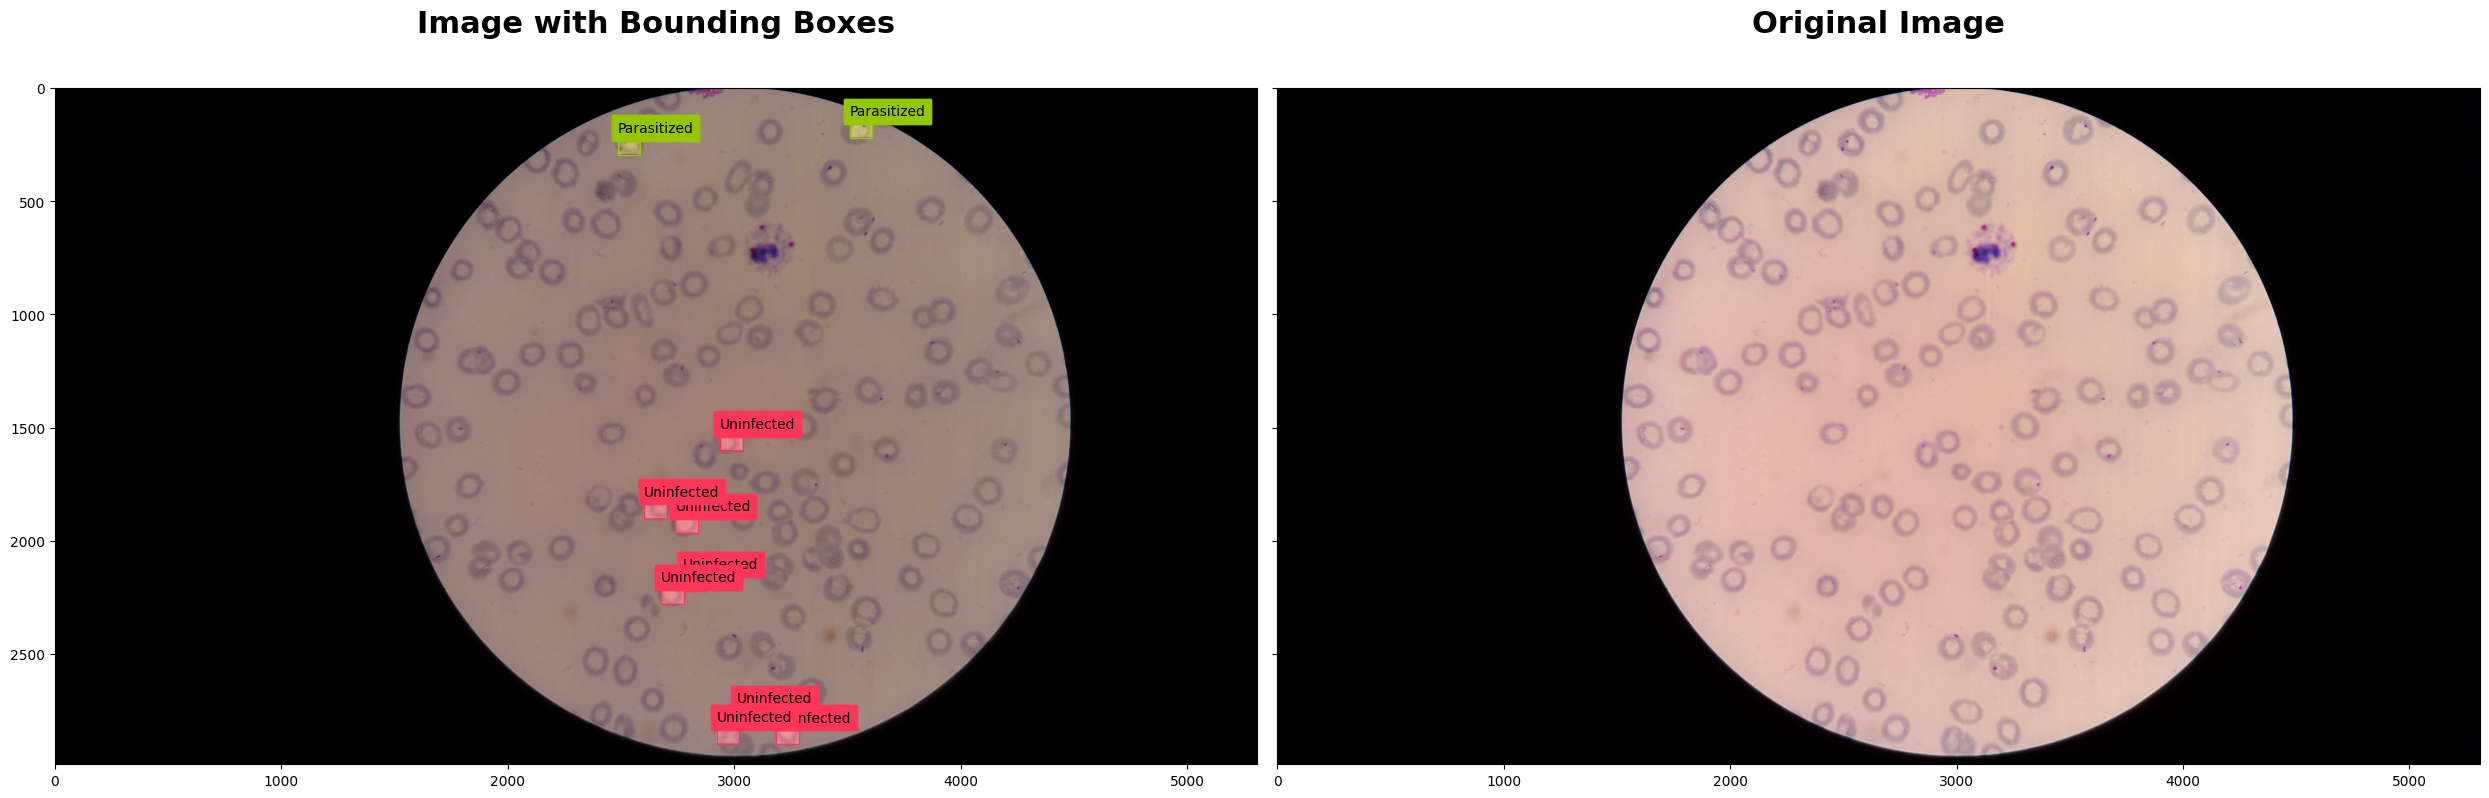

In [32]:
# plot sample

img_path = "143C39P4thinF_original/Img/IMG_20150622_105253.jpg"

label2hex = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}
label2rgb = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), rgbcolors)}

plot_data_example(df, root_dir_point, img_path, colors=label2hex)

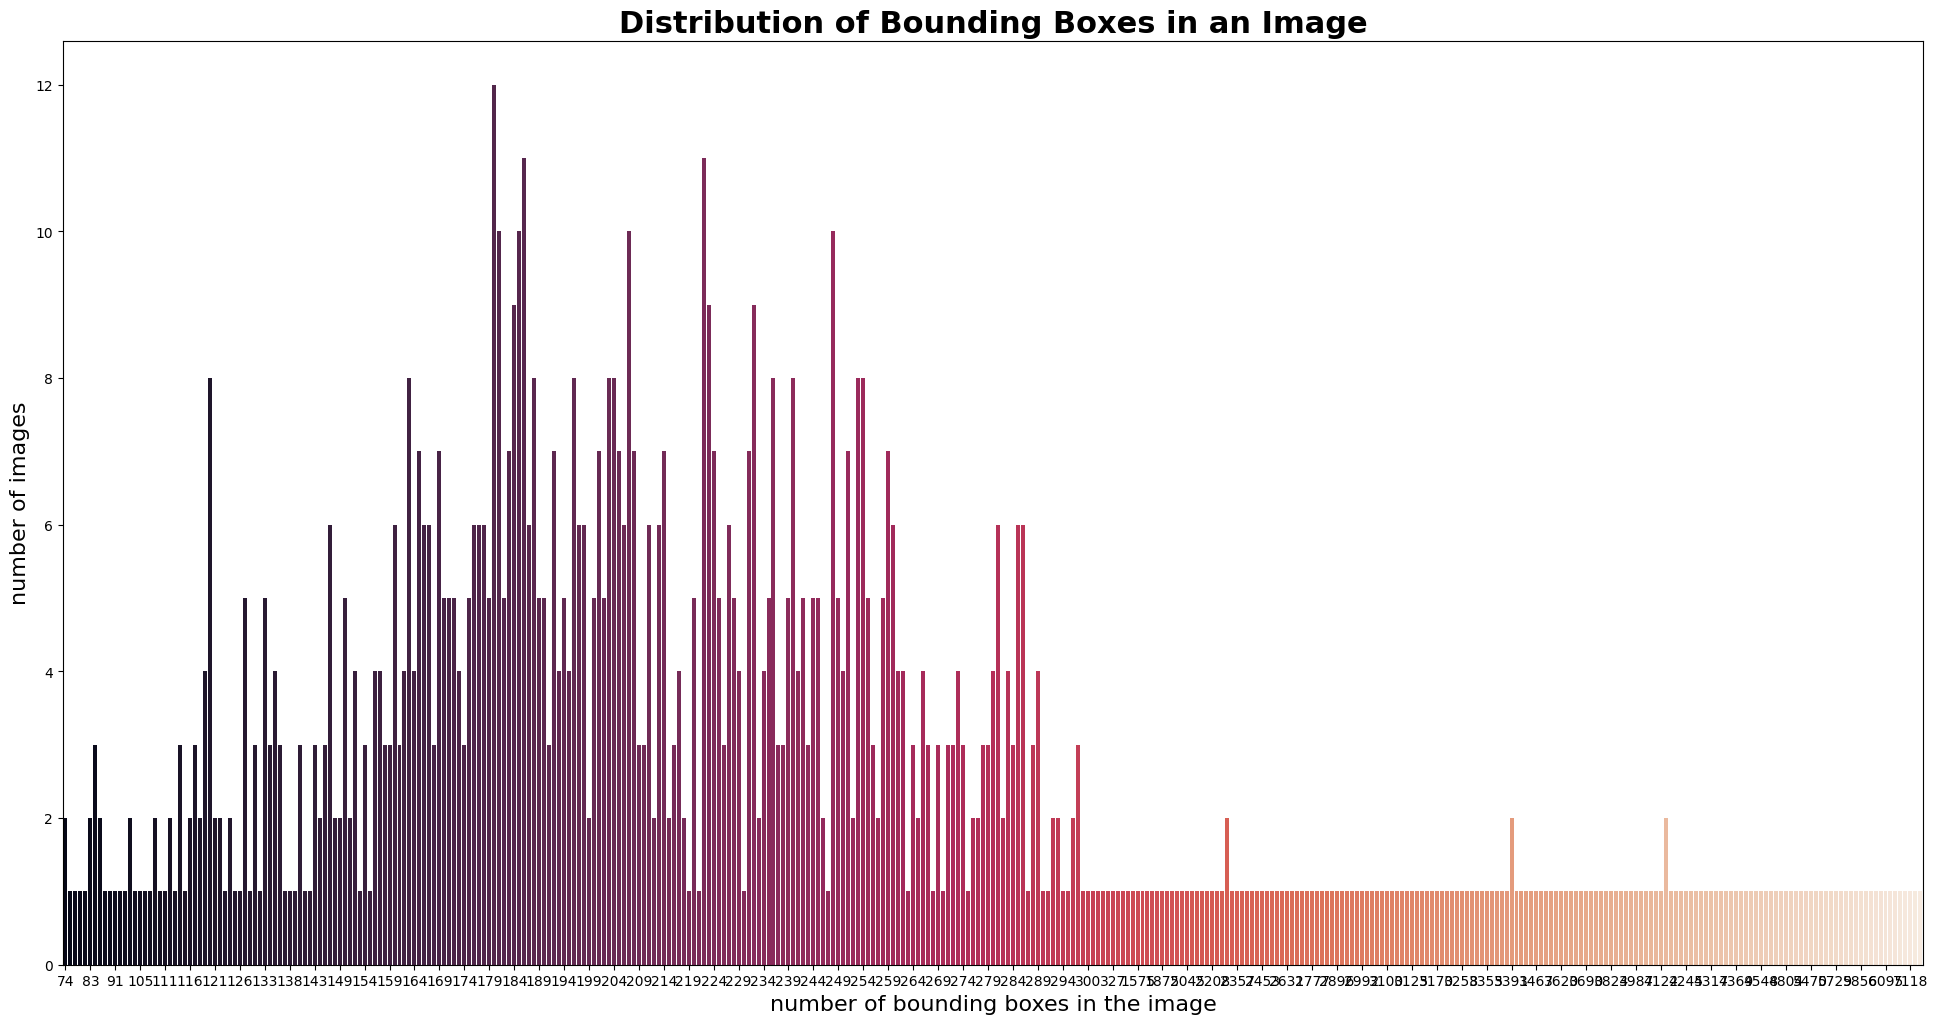

In [24]:
fig, ax = plt.subplots(figsize=(24,12))

sns.countplot(x=df.groupby('path')['path'].count(), palette='rocket')

ax.set_xticks(ax.get_xticks()[::5]);

ax.set_ylabel('number of images', fontsize=16)
ax.set_xlabel('number of bounding boxes in the image', fontsize=16)

ax.set_title("Distribution of Bounding Boxes in an Image", fontsize=22, fontweight='bold');